# **Discriminant analysis for revealing neuronal tendencies captured by sensitivity values**

## Navigation

- [**Basic imports and initialization**](#Basic-imports-and-initialization)
- [**1. Alexnet**](#1.-Alexnet)
- [**2. VGG11**](#2.-VGG11)
- [**3. ResNet18**](#3.-ResNet18)

## Basic imports and initialization

$\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#1.-Alexnet)

- [Limiting the hardware resources, importing packages](#Limiting-the-hardware-resources,-importing-packages)
- [Initializing common variables](#Initializing-common-variables)

### Limiting the hardware resources, importing packages

$\quad$[[Back to section]](#Basic-imports-and-initialization)$\quad$[[Next subsect.$\to$]](#Initializing-common-variables)

To provide easy access to modules stored in the ```../src/``` directory, we use the following workaround:

In [1]:
import sys
sys.path.append('../src/')

Next, we limit the hardware usage:

In [2]:
# set limitations on hardware
import hardware_setup
hardware_setup.mkl_set_num_threads(num_threads=4)

[mkl]: set up num_threads=4/24


Then we import all necessary packages:

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sensitivity_analysis.preprocess_visualize
import sensitivity_analysis.augmentation_setting

import discriminant_analysis.compute
import discriminant_analysis.plot

import prediction.compute

import preparation.single_unit
import preparation.visualize

import data_loader.utils

### Initializing common variables

[[$\leftarrow$Prev.subsect.]](#Limiting-the-hardware-resources,-importing-packages)$\quad$[[Back to section]](#Basic-imports-and-initialization)$\quad$

In [4]:
data_dirname = '../data/imagenet'
activations_dirname = '../results/'
model_dirname = '../torch-models/'
exp_relative_path = '../experiments/'

values_fnm_base = 'imagenet_ILSVRC_values'
augmentation_set_numbers_list = [1, 2]

In [5]:
values_names_list = [
    'rbscc (train)',
    'rbscc (valid)',
    'shpv',
    'si',
    'siT'
]
values_names_list_2 = [
    'shpv',
    'si',
    'siT'
]

values_cov_pairs_dict = {
    'shpv': 'shptv',
    'si': 'sitv',
    'siT': 'sitv'
}
cov_values_names_dict = {
    'sitv': ('var', 'mean'),
    'shptv': ('var', 'mean'),
    #'sitv': 'var',
    #'shptv': 'var',
}
cov_values_funcs = {
    'sitv': {
        'mean': None,
        'var': None,
        ('var', 'mean'): lambda x: sensitivity_analysis.preprocess_visualize.compute_coef_var(x, log=False),
    },
    'shptv': {
        'means': None,
        'var': None,
        ('var', 'mean'): lambda x: sensitivity_analysis.preprocess_visualize.compute_coef_var(x, log=False),
    }
}


shpv_group_indices_dict = {}
for augmentation_set_number in augmentation_set_numbers_list:
    shpv_group_indices_dict[
        augmentation_set_number
    ] = sensitivity_analysis.augmentation_setting.get_group_variables_indices(
        augmentation_set_number,
        use_permutation_variable=True,
        use_class_variable=True,
        use_partition_variable=True
    )

values_names = ['shpv', 'si', 'siT']

In [6]:
#corr_type = 'pearson'
corr_type = 'spearman'

show = True
plot_colorbar = True

figsize_lda = (20, 8)
figsize_corr_hist = (20, 3)
figsize_corr_consolidated = (18, 4)

cmap_corr = 'RdBu_r'
cmap_corr_consolidated = 'twilight'
color_cumul = 'salmon'
color_bins = 'firebrick'
cmap_cross_corr_consolidated = 'twilight_shifted'
cmap_cvs_consolidated = 'twilight_shifted_r'

figsize_cross_corr = (14, 6)
figsize_cross_corr_hist = (12, 3)
figsize_cross_corr_consolidated = (18, 4)

figsize_cvs_corr = (25, 4)
figsize_cvs_consolidated = (25, 4)

## 1. Alexnet

[[$\leftarrow$ Prev.part]](#Basic-imports-and-initialization) $\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#2.-VGG11)

- [1.1 Setting up the configuration variables](#1.1-Setting-up-the-configuration-variables)
- [1.2 2D LDA projections](#1.2-2D-LDA-projections)
- [1.3 LDA confusion matrices](#1.3-LDA-confusion-matrices)

### 1.1 Setting up the configuration variables

$\quad$ [[Back to section]](#1.-Alexnet)$\quad$[[Next subsect.$\to$]](#1.2-2D-LDA-projections)

In [7]:
alexnet_network_name = 'alexnet'
alexnet_network_modules = [
    'features.2', # Conv2d + ReLU + MaxPool2d
    'features.5', # ... + Conv2d + ReLU + MaxPool2d
    'features.7', # ... + Conv2d + ReLU
    'features.9', # ... + Conv2d + ReLU
    #'features.12', # ... + Conv2d + ReLU + MaxPool2d
    'avgpool', # ... + Conv2d + ReLU + MaxPool2d + AdaptiveAvgPool
    'classifier.2', # ... + Linear + ReLU
    'classifier.5', # ... + Linear + ReLU
    'classifier.6', # ... + Linear
]
alexnet_n_conv_modules = len(
    list(filter(lambda x: ('features' in x) or ('avgpool' in x), alexnet_network_modules))
)

alexnet_values_fnms_dict = preparation.single_unit.extract_massive_values_fnms(
    alexnet_network_name,
    values_fnm_base,
    augmentation_set_numbers_list,
    prefix=None
);

In [8]:
alexnet_sensitivity_values_dict = {}
for val_name in values_names:
    alexnet_sensitivity_values_dict[val_name] = prediction.compute.get_all_values(
        alexnet_values_fnms_dict,
        activations_dirname,
        alexnet_network_modules,
        val_name,
        augmentation_set_numbers_list,
        shpv_group_indices_dict,
        extract_auxilliary_names=True,
    )

### 1.2 2D LDA projections

[[$\leftarrow$Prev.subsect.]](#1.1-Setting-up-the-configuration-variables)$\quad$[[Back to section]](#1.-Alexnet)$\quad$[[Next subsect.$\to$]](#1.3-LDA-confusion-matrices)

In [36]:
alexnet_projected_sensitivity_values_dict = (
    discriminant_analysis.compute.project_2d_lda(
        alexnet_sensitivity_values_dict,
        alexnet_network_modules,
        augmentation_set_numbers_list,
        values_names,
        alexnet_n_conv_modules,
        extract_auxilliary_names=True,
    )
)

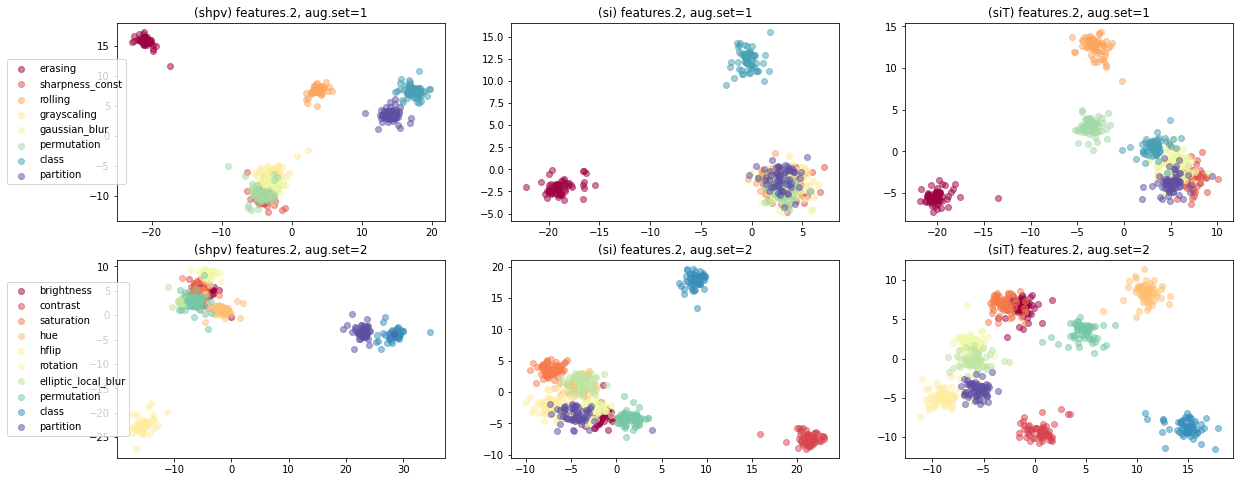

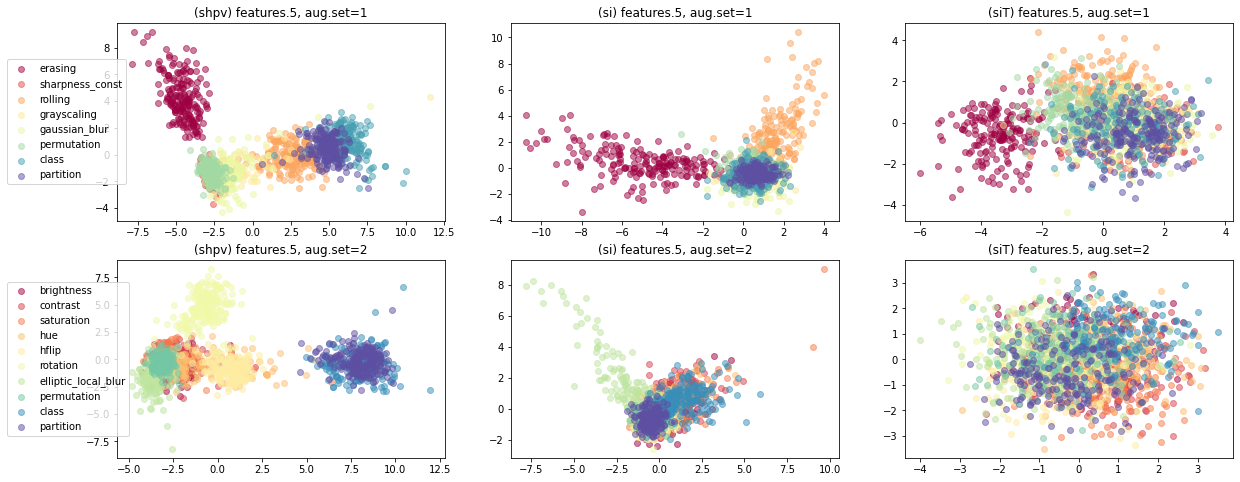

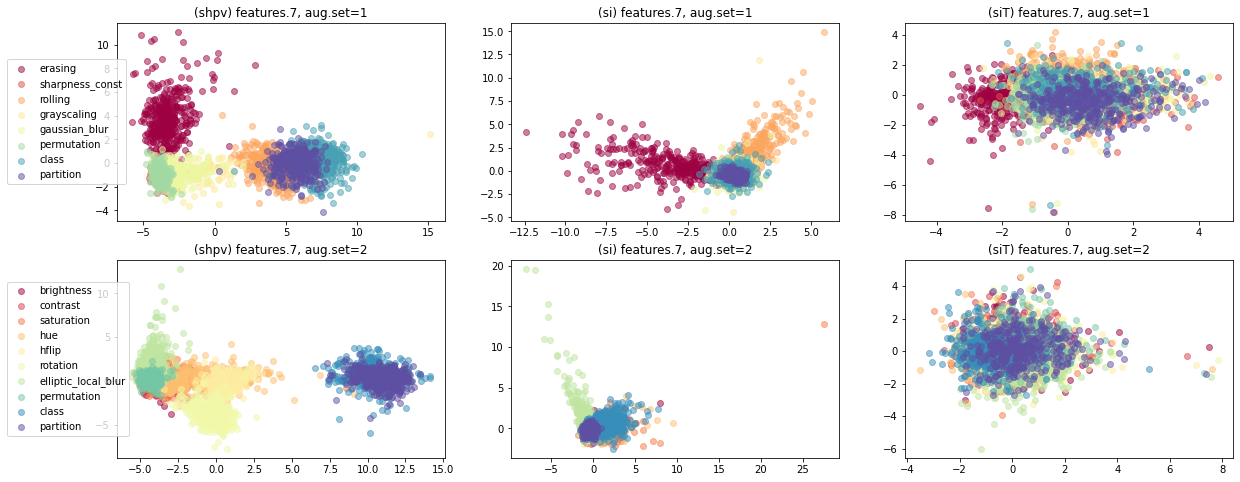

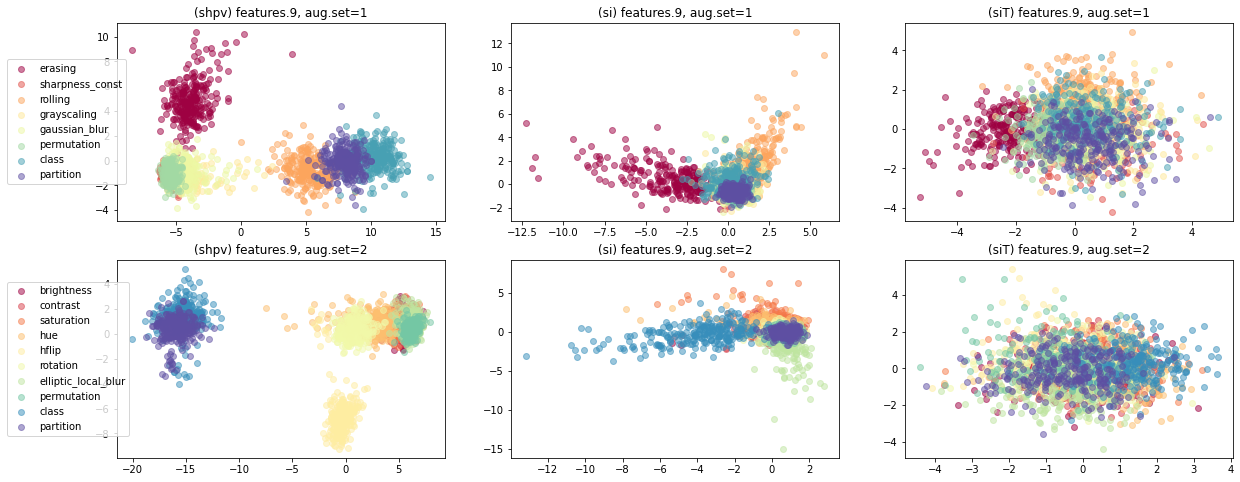

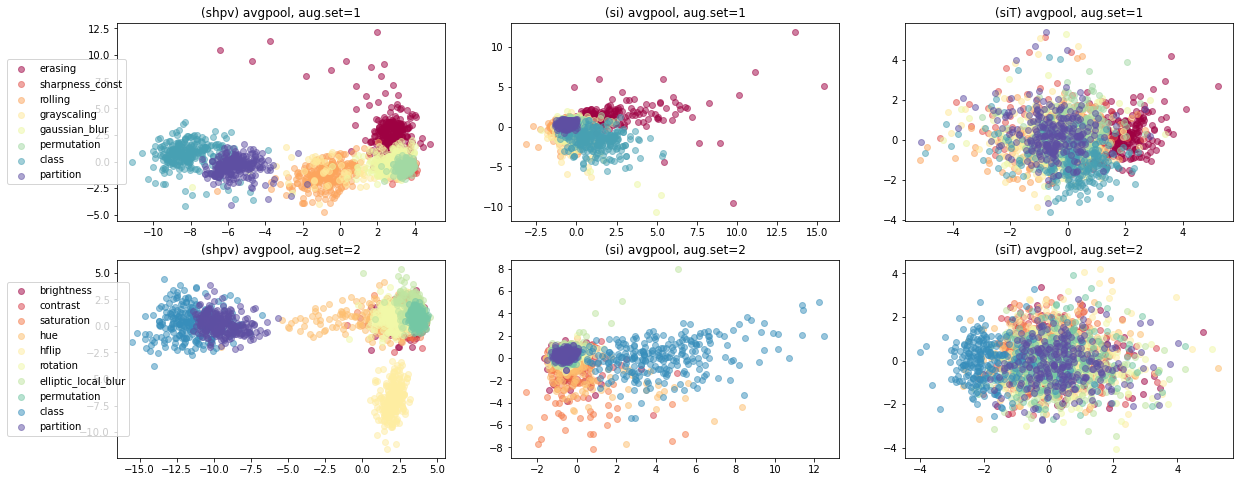

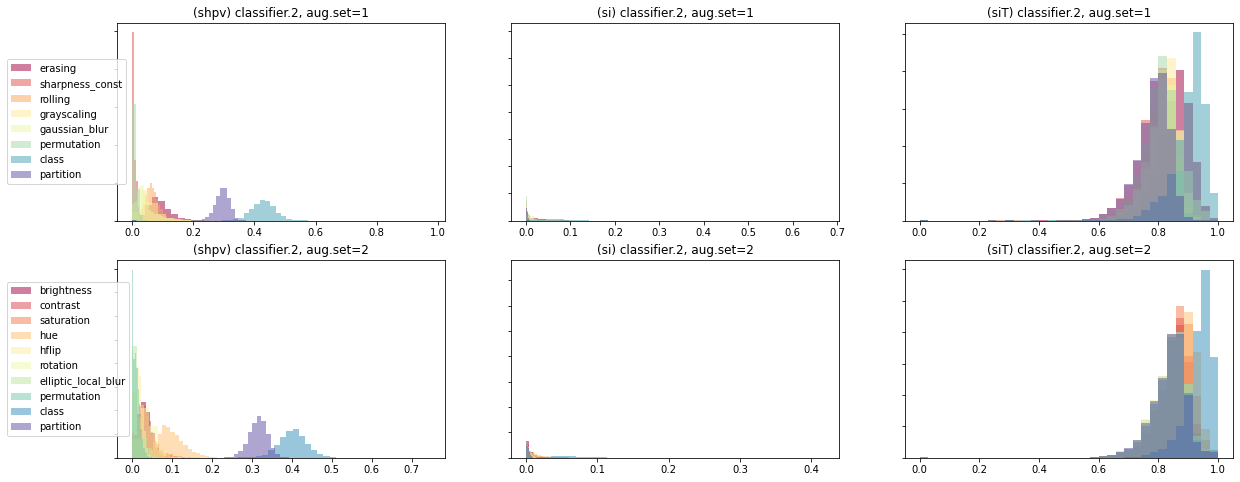

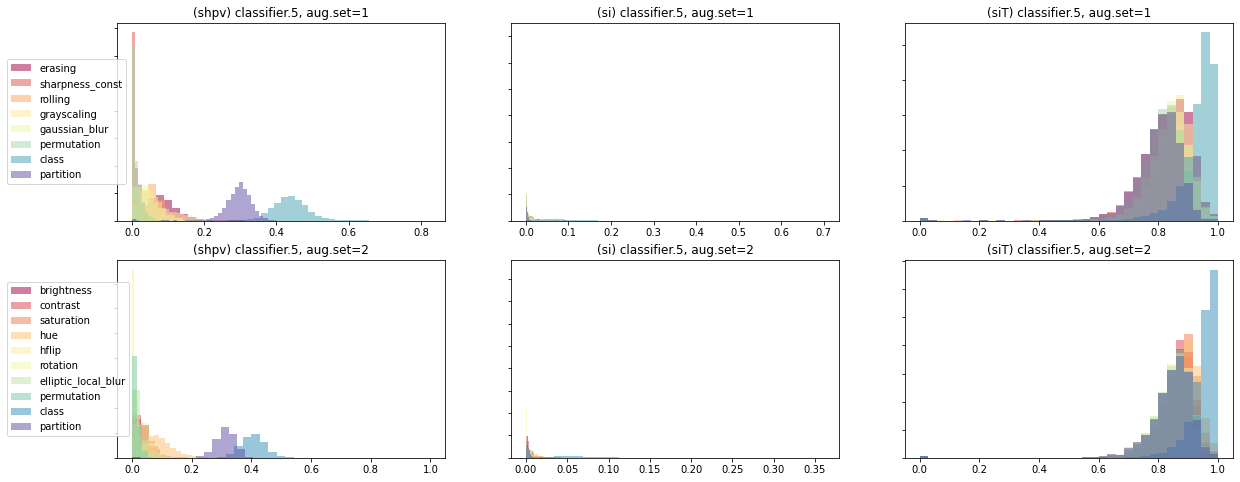

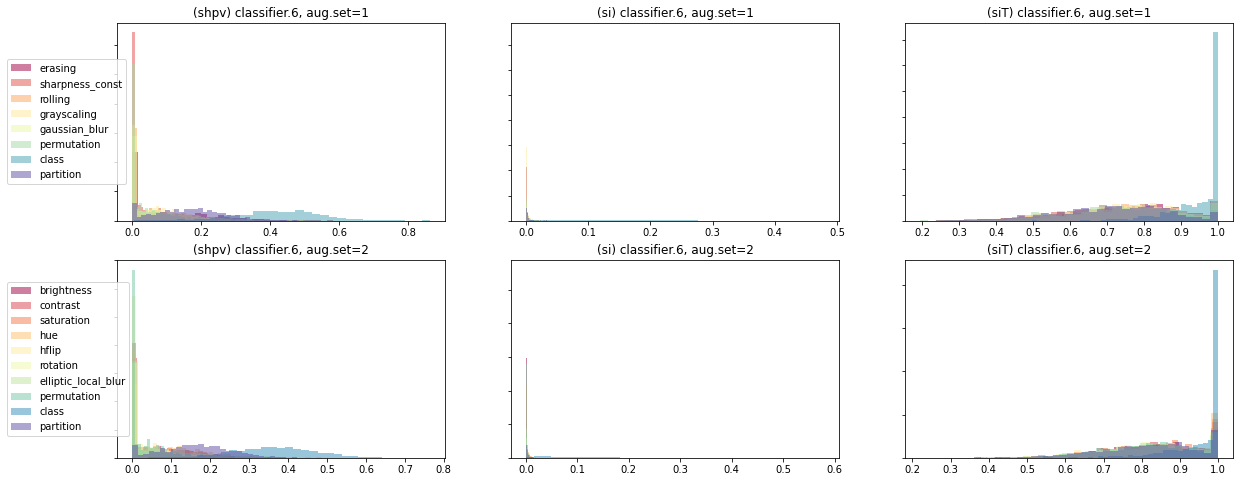

In [11]:
discriminant_analysis.plot.plot_lda_2d_projections_and_hists(
    alexnet_projected_sensitivity_values_dict,
    alexnet_sensitivity_values_dict,
    alexnet_network_modules,
    augmentation_set_numbers_list,
    values_names,
    alexnet_n_conv_modules,
    extract_auxilliary_names=True,
    figsize=figsize_lda,
    cmap='Spectral',
    show=True,
    alpha=0.5,
)

### 1.3 LDA confusion matrices

[[$\leftarrow$Prev.subsect.]](#1.2-2D-LDA-projections)$\quad$[[Back to section]](#1.-Alexnet)$\quad$

In [12]:
alexnet_conf_mat_dict, alexnet_acc_dict = (
    discriminant_analysis.compute.compute_mean_valid_confusion_matrices(
        alexnet_sensitivity_values_dict,
        alexnet_network_modules,
        augmentation_set_numbers_list,
        values_names,
        alexnet_n_conv_modules,
        repeated_kfold_n_splits=5,
        repeated_kfold_n_repeats=100,
        random_state=0,
        extract_auxilliary_names=True,
    )
)

In [13]:
alexnet_cmacc_filename = 'lda_alexnet_conf_mat_acc.pkl'
alexnet_cmacc_save_path = os.path.join(
    activations_dirname, alexnet_cmacc_filename
)

In [14]:
data_loader.utils.save_pickled_data(
    {
        'alexnet_conf_mat_dict': alexnet_conf_mat_dict,
        'alexnet_acc_dict': alexnet_acc_dict,
    },
    alexnet_cmacc_save_path
)

In [15]:
tmp = data_loader.utils.load_pickled_data(alexnet_cmacc_save_path)
alexnet_conf_mat_dict = tmp['alexnet_conf_mat_dict']
alexnet_acc_dict = tmp['alexnet_acc_dict']


			features.2



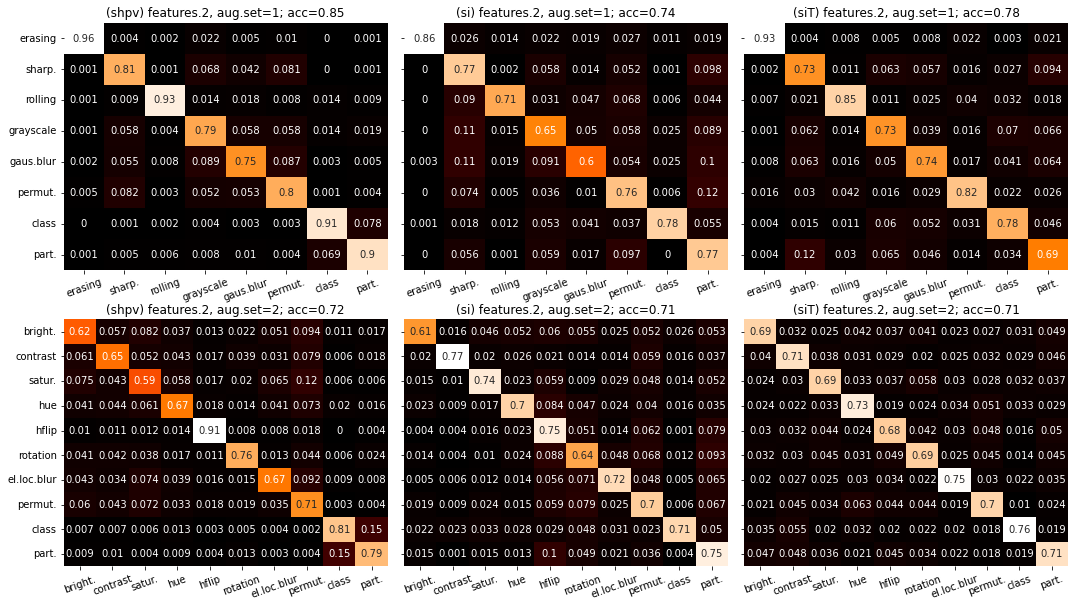


			features.5



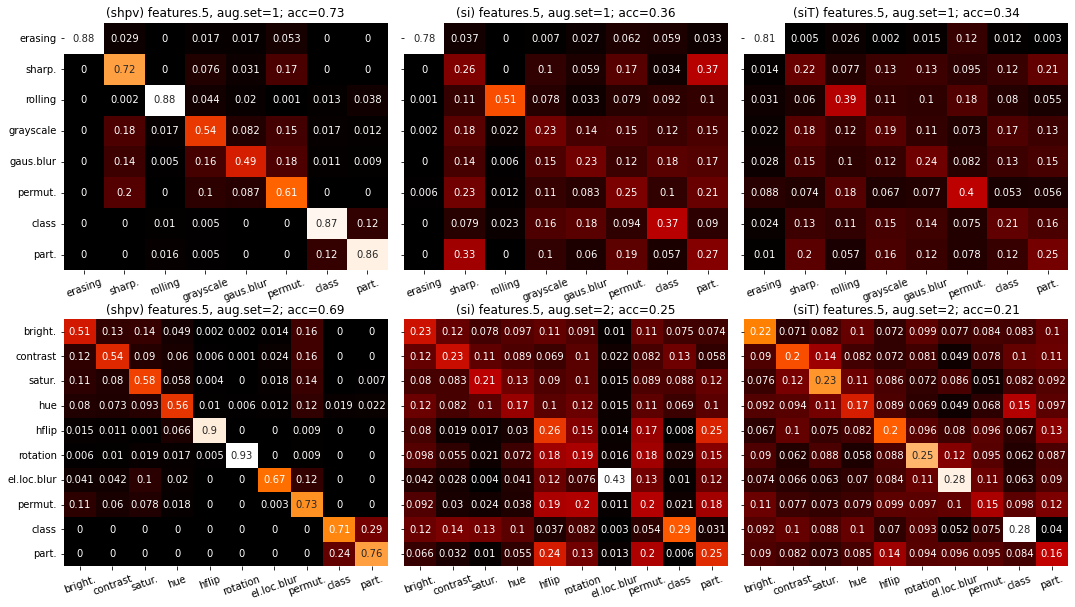


			features.7



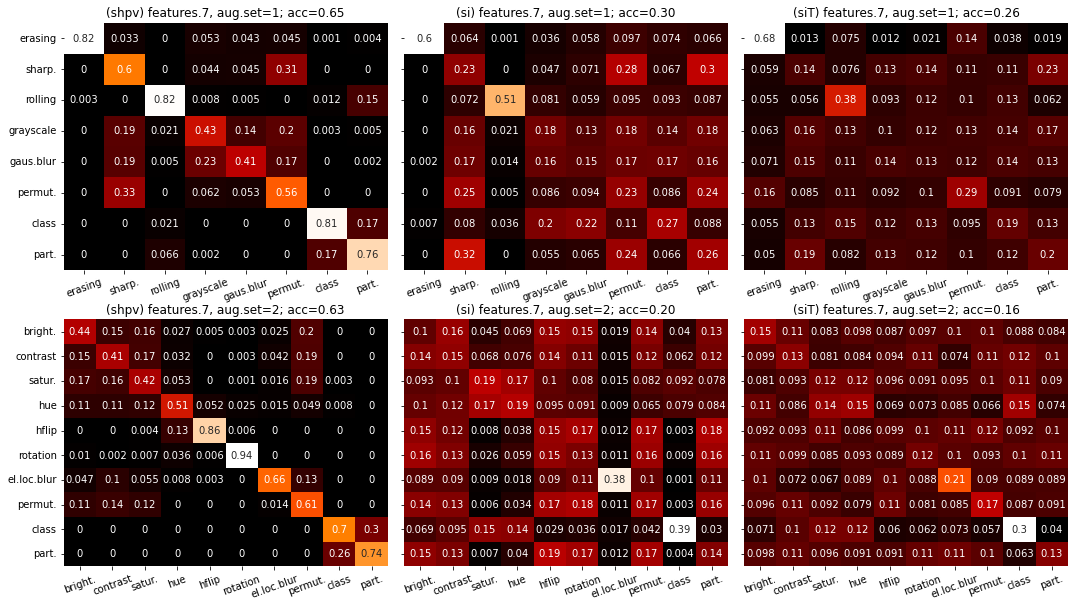


			features.9



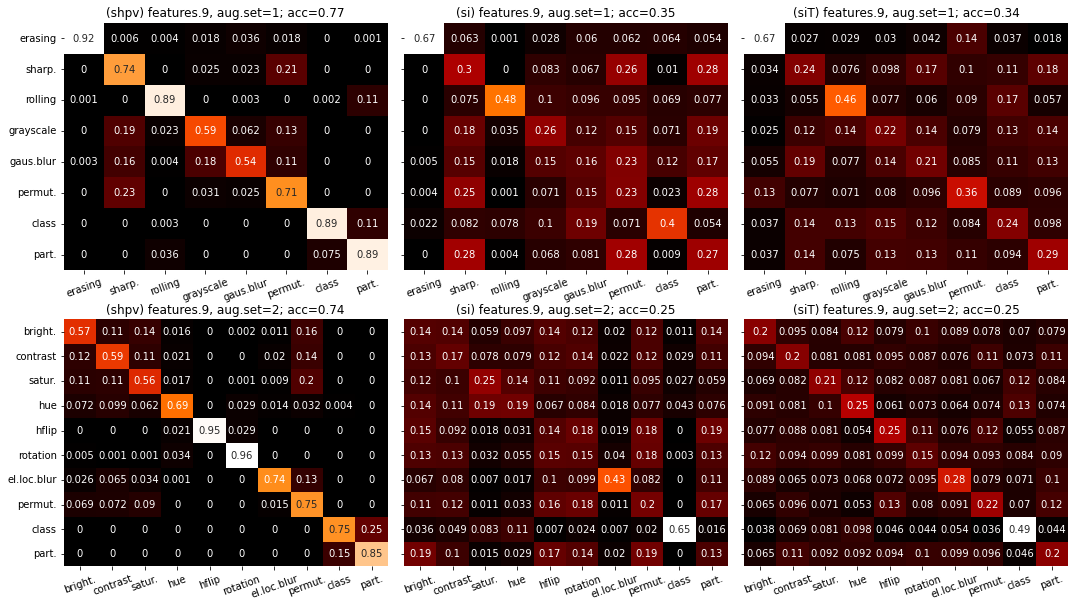


			avgpool



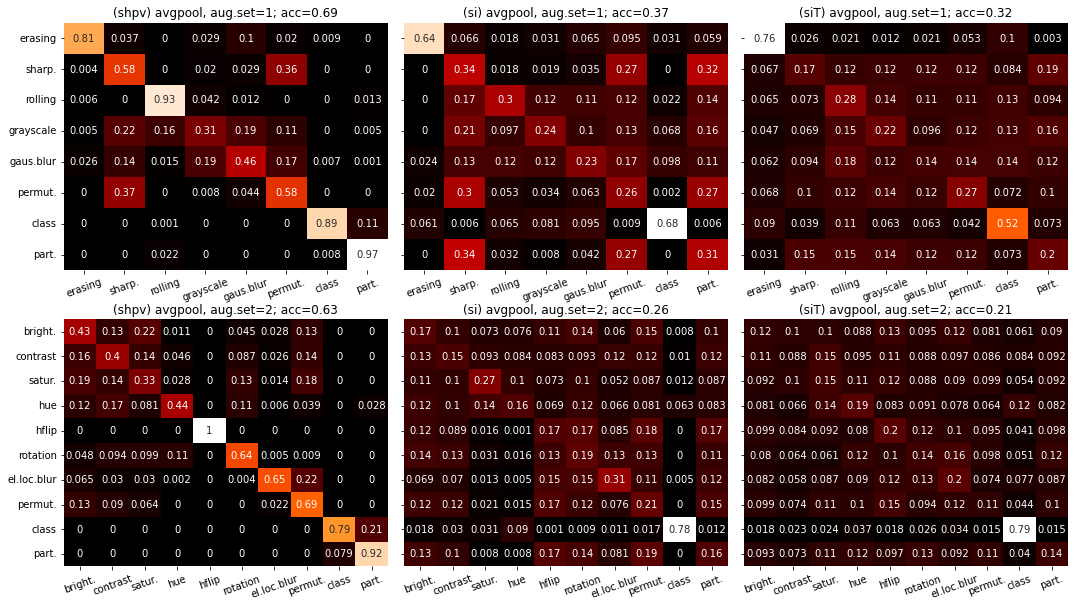

In [16]:
save_dirname = '../results/alexnet/lda_confmat/'
os.makedirs(save_dirname, exist_ok=True)
save_filename_base = f'lda_confmat'

discriminant_analysis.plot.plot_confusion_matrices(
    alexnet_conf_mat_dict,
    alexnet_acc_dict,
    alexnet_network_modules,
    augmentation_set_numbers_list,
    values_names,
    alexnet_n_conv_modules,
    extract_auxilliary_names=True,
    which='valid',
    n_round=3,
    figsize=(18, 10),
    cmap='gist_heat',
    show=True,
    save_dirname=save_dirname,
    save_filename_base=save_filename_base,
)

## 2. VGG11

[[$\leftarrow$ Prev.part]](#1.-Alexnet) $\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#3.-ResNet18)

- [2.1 Setting up the configuration variables](#2.1-Setting-up-the-configuration-variables)
- [2.2 2D LDA projections](#2.2-2D-LDA-projections)
- [2.3 LDA confusion matrices](#2.3-LDA-confusion-matrices)

### 2.1 Setting up the configuration variables

$\quad$ [[Back to section]](#2.-VGG11)$\quad$[[Next subsect.$\to$]](#2.2-2D-LDA-projections)

In [17]:
vgg11_network_name = 'vgg11'
vgg11_network_modules = [
    'features.2', # conv2d -> ReLU -> MaxPool2d
    'features.5', # conv2d -> ReLU -> MaxPool2d
    #'features.7', # conv2d -> ReLU ->
    'features.10', # conv2d -> ReLU -> MaxPool2d
    #'features.12', # conv2d -> ReLU ->
    'features.15', # conv2d -> ReLU -> MaxPool2d
    #'features.17', # conv2d -> ReLU ->
    #'features.20', # conv2d -> ReLU -> MaxPool2d ->
    'avgpool',
    'classifier.1', # Linear -> ReLU
    'classifier.4', # Linear -> ReLU
    'classifier.6', # Linear -> ReLU
]
vgg11_n_conv_modules = len(
    list(filter(lambda x: ('features' in x) or ('avgpool' in x), vgg11_network_modules))
)

vgg11_values_fnms_dict = preparation.single_unit.extract_massive_values_fnms(
    vgg11_network_name,
    values_fnm_base,
    augmentation_set_numbers_list,
    prefix=None
);

In [18]:
vgg11_sensitivity_values_dict = {}
for val_name in values_names:
    vgg11_sensitivity_values_dict[val_name] = prediction.compute.get_all_values(
        vgg11_values_fnms_dict,
        activations_dirname,
        vgg11_network_modules,
        val_name,
        augmentation_set_numbers_list,
        shpv_group_indices_dict,
        extract_auxilliary_names=True,
    )

### 2.2 2D LDA projections

[[$\leftarrow$Prev.subsect.]](#2.1-Setting-up-the-configuration-variables)$\quad$[[Back to section]](#2.-VGG11)$\quad$[[Next subsect.$\to$]](#2.3-LDA-confusion-matrices)

In [19]:
vgg11_projected_sensitivity_values_dict = (
    discriminant_analysis.compute.project_2d_lda(
        vgg11_sensitivity_values_dict,
        vgg11_network_modules,
        augmentation_set_numbers_list,
        values_names,
        vgg11_n_conv_modules,
        extract_auxilliary_names=True,
    )
)

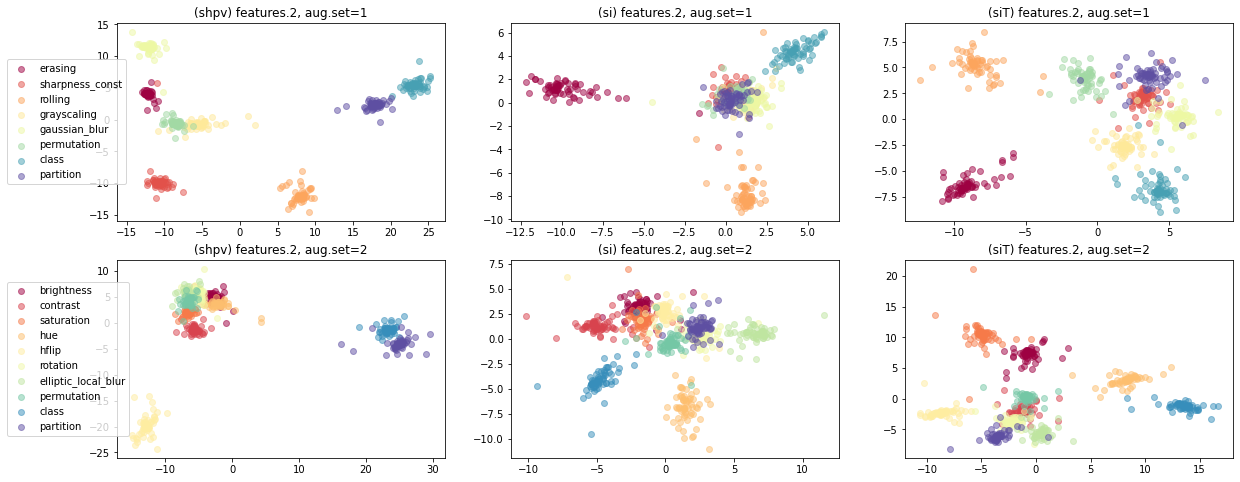

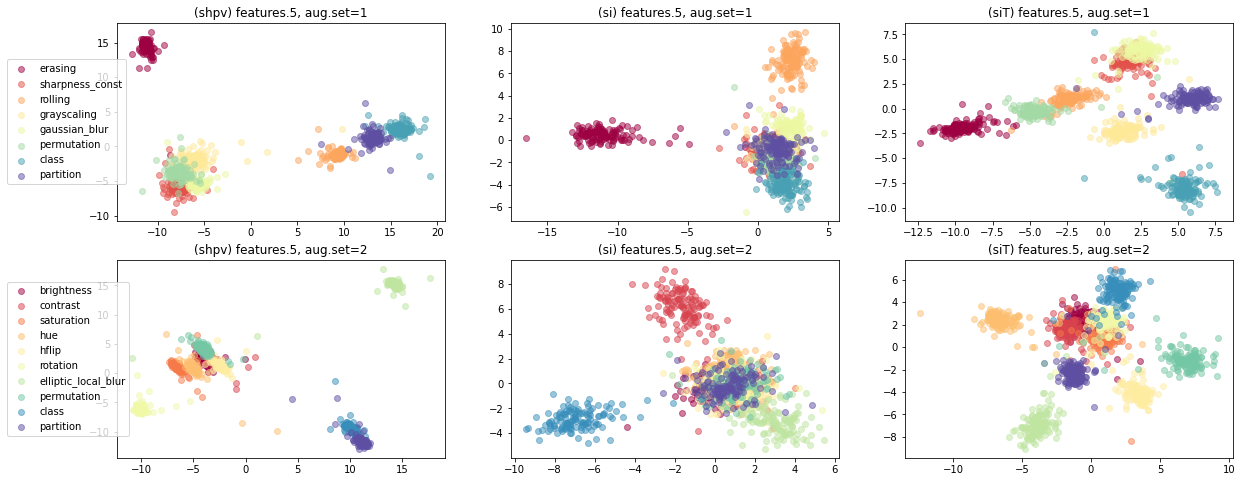

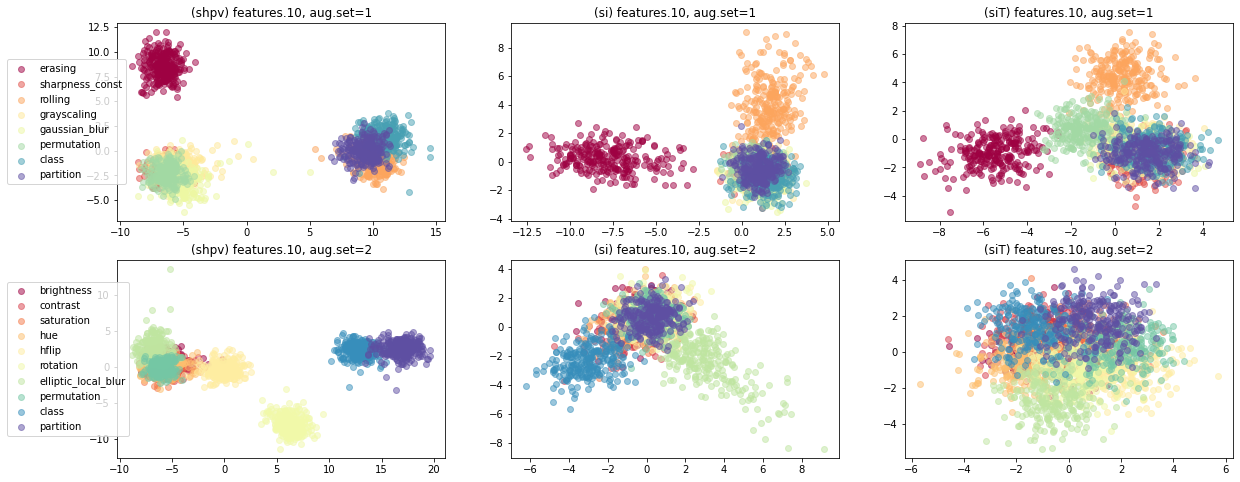

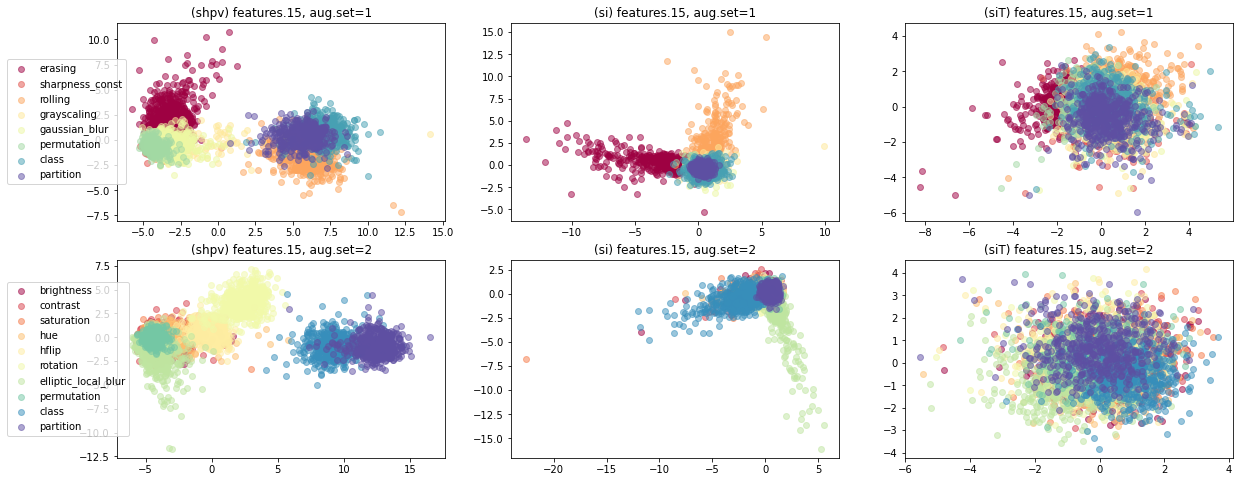

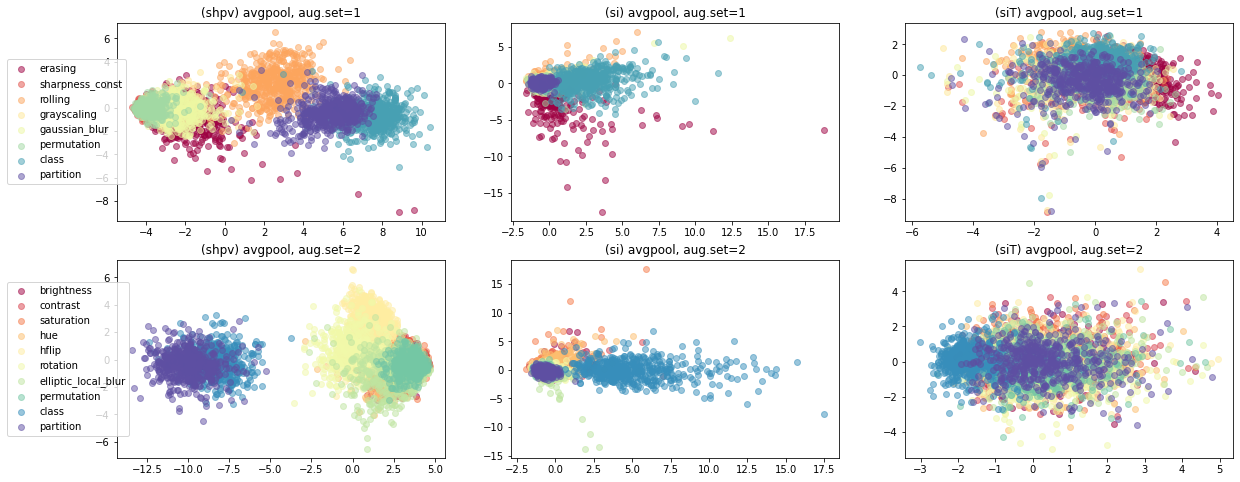

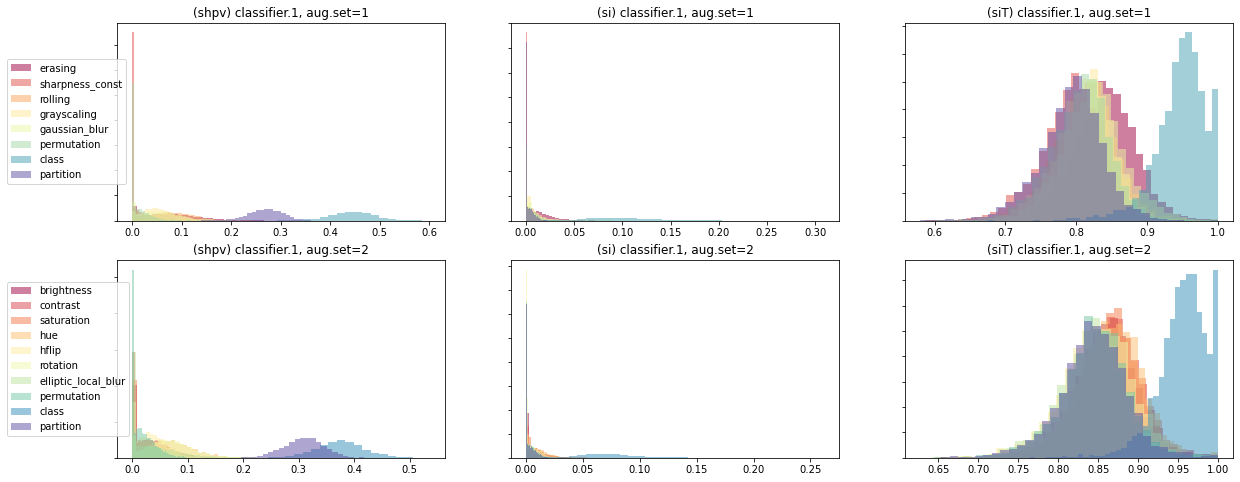

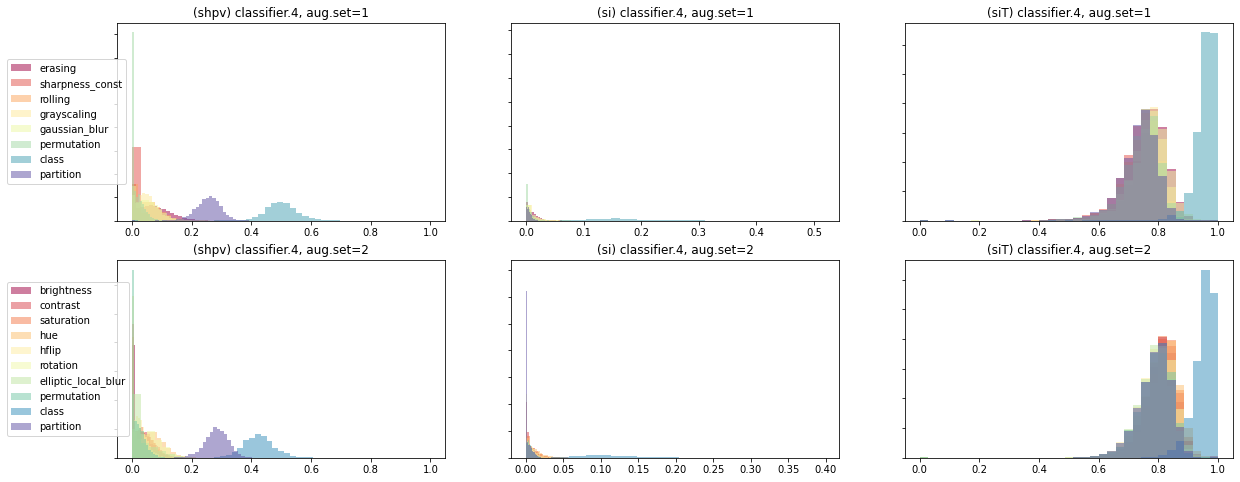

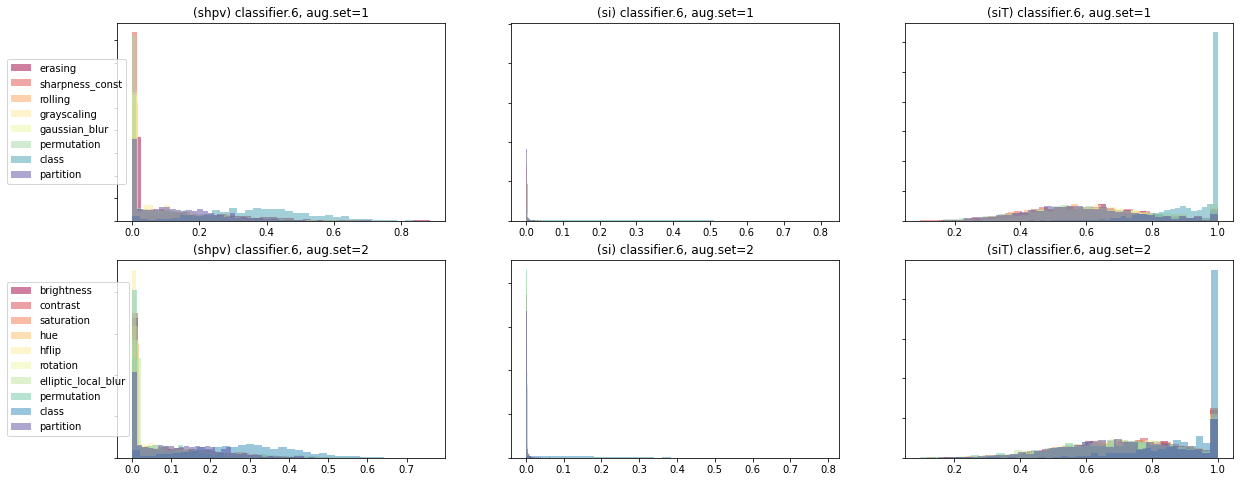

In [20]:
discriminant_analysis.plot.plot_lda_2d_projections_and_hists(
    vgg11_projected_sensitivity_values_dict,
    vgg11_sensitivity_values_dict,
    vgg11_network_modules,
    augmentation_set_numbers_list,
    values_names,
    vgg11_n_conv_modules,
    extract_auxilliary_names=True,
    figsize=figsize_lda,
    cmap='Spectral',
    show=True,
    alpha=0.5,
)

### 2.3 LDA confusion matrices

[[$\leftarrow$Prev.subsect.]](#2.2-2D-LDA-projections)$\quad$[[Back to section]](#2.-VGG11)$\quad$

In [ ]:
vgg11_conf_mat_dict, vgg11_acc_dict = (
    discriminant_analysis.compute.compute_mean_valid_confusion_matrices(
        vgg11_sensitivity_values_dict,
        vgg11_network_modules,
        augmentation_set_numbers_list,
        values_names,
        vgg11_n_conv_modules,
        repeated_kfold_n_splits=5,
        repeated_kfold_n_repeats=100,
        random_state=0,
        extract_auxilliary_names=True,
    )
)

In [ ]:
vgg11_cmacc_filename = 'lda_vgg11_conf_mat_acc.pkl'
vgg11_cmacc_save_path = os.path.join(
    activations_dirname, vgg11_cmacc_filename
)

In [ ]:
data_loader.utils.save_pickled_data(
    {
        'vgg11_conf_mat_dict': vgg11_conf_mat_dict,
        'vgg11_acc_dict': vgg11_acc_dict,
    },
    vgg11_cmacc_save_path
)

In [34]:
tmp = data_loader.utils.load_pickled_data(vgg11_cmacc_save_path)
vgg11_conf_mat_dict = tmp['vgg11_conf_mat_dict']
vgg11_acc_dict = tmp['vgg11_acc_dict']


			features.2



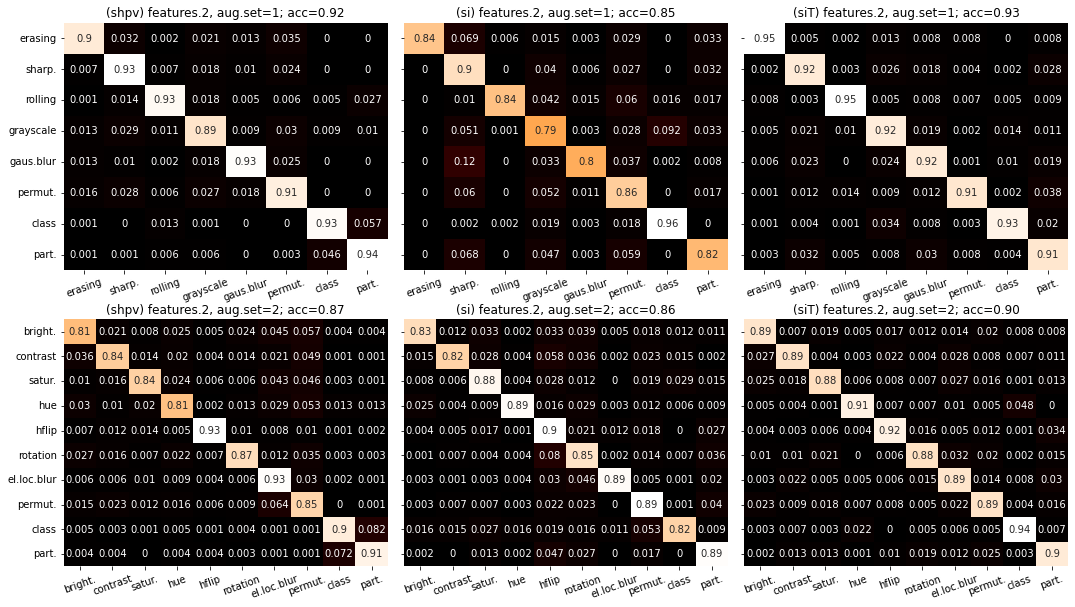


			features.5



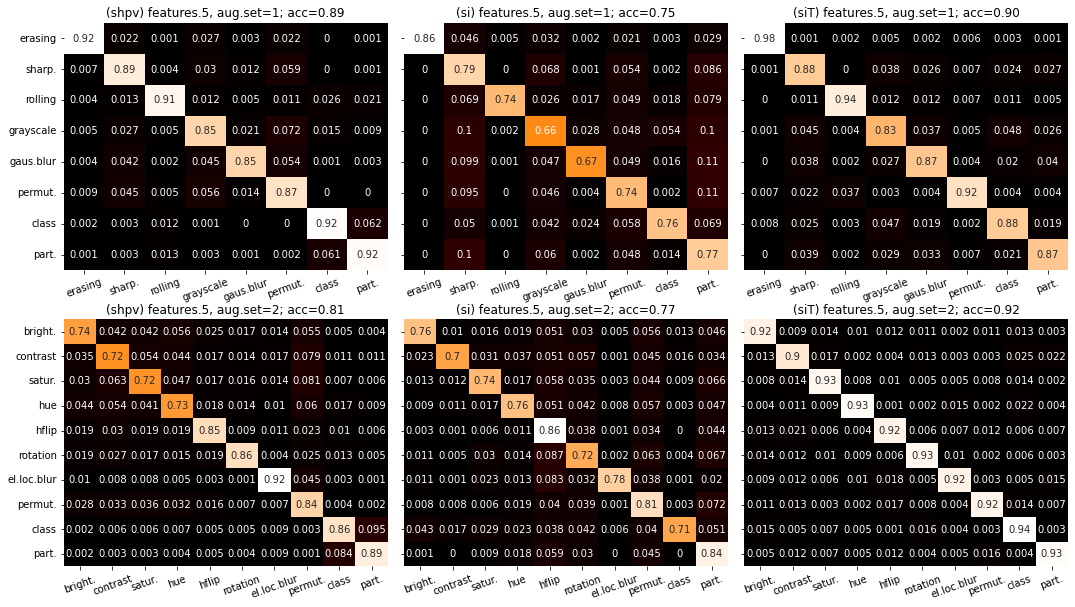


			features.10



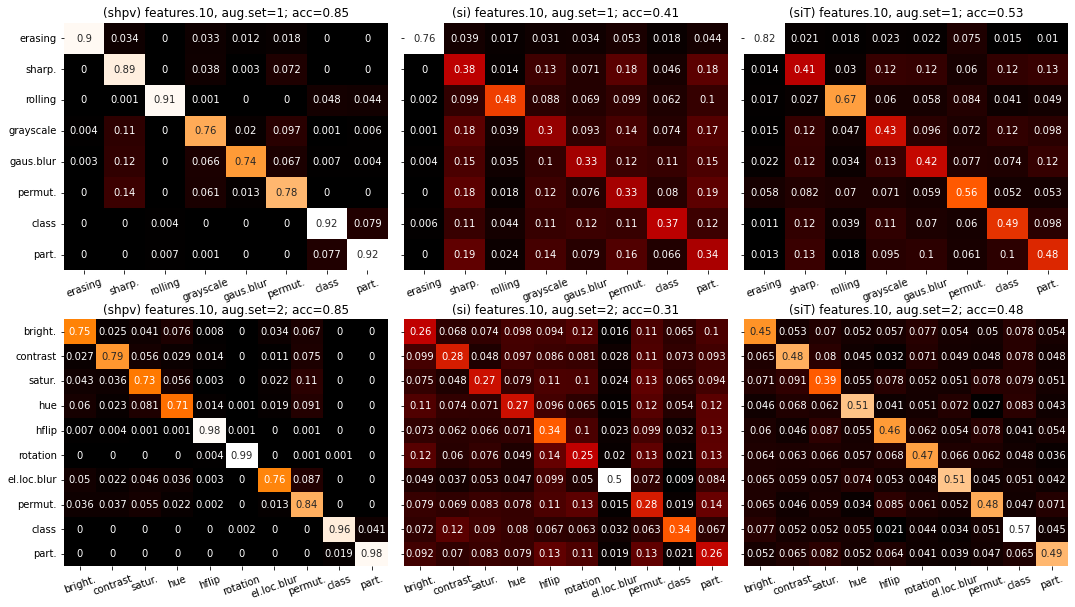


			features.15



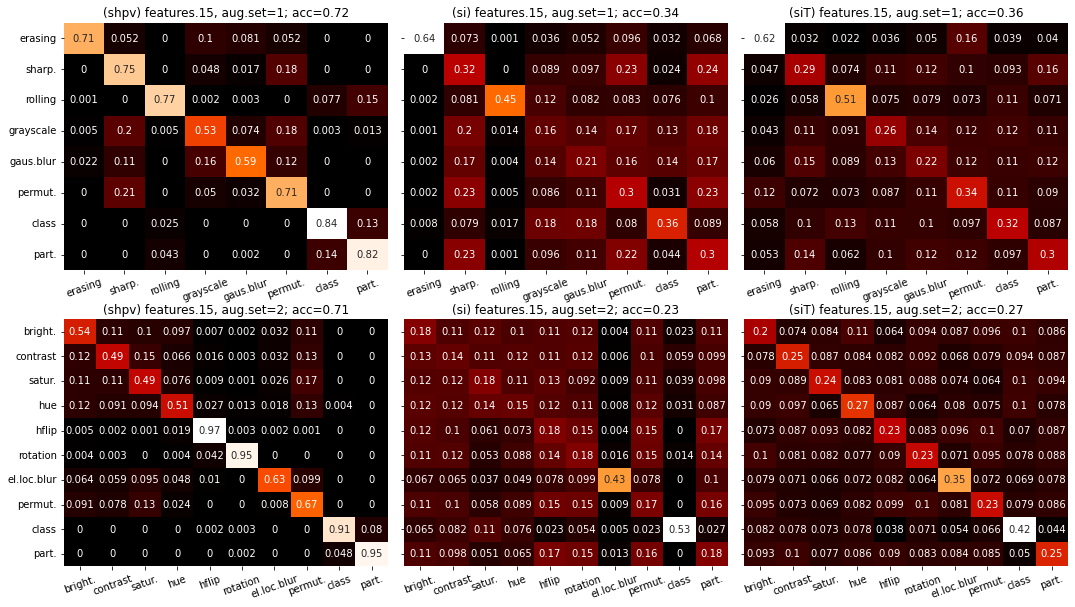


			avgpool



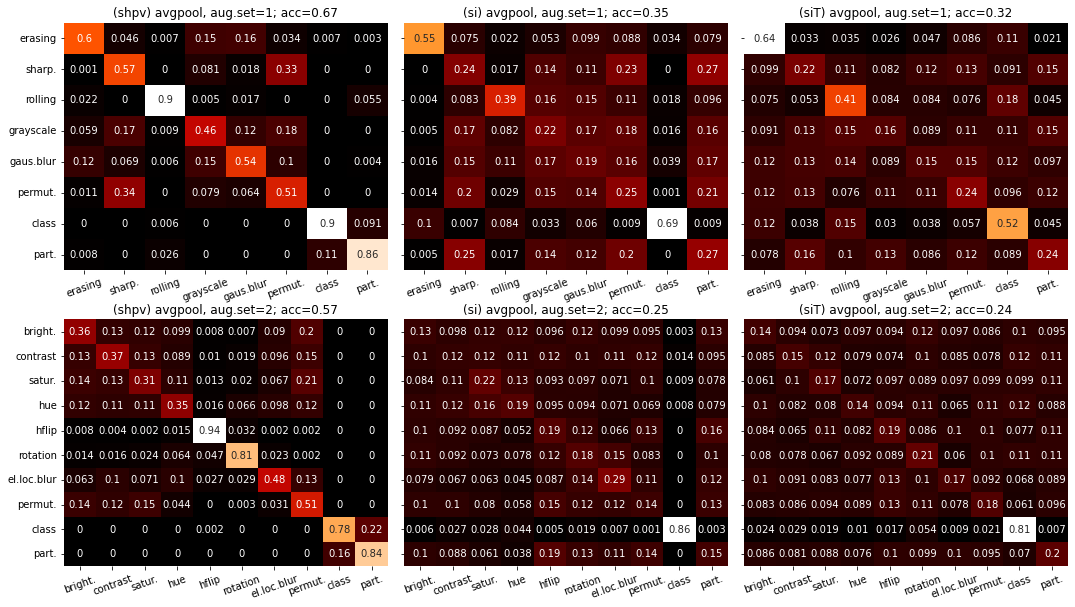

In [35]:
save_dirname = '../results/vgg11/lda_confmat/'
os.makedirs(save_dirname, exist_ok=True)
save_filename_base = f'lda_confmat'


discriminant_analysis.plot.plot_confusion_matrices(
    vgg11_conf_mat_dict,
    vgg11_acc_dict,
    vgg11_network_modules,
    augmentation_set_numbers_list,
    values_names,
    vgg11_n_conv_modules,
    extract_auxilliary_names=True,
    which='valid',
    n_round=3,
    figsize=(18, 10),
    cmap='gist_heat',
    show=True,
    save_dirname=save_dirname,
    save_filename_base=save_filename_base,
)

## 3. ResNet18

[[$\leftarrow$ Prev.part]](#2.-VGG11) $\qquad$ [[Back to top]](#Navigation) $\qquad$

- [3.1 Setting up the configuration variables](#3.1-Setting-up-the-configuration-variables)
- [3.2 2D LDA projections](#3.2-2D-LDA-projections)
- [3.3 LDA confusion matrices](#3.3-LDA-confusion-matrices)

### 3.1 Setting up the configuration variables

$\quad$ [[Back to section]](#3.-ResNet18)$\quad$[[Next subsect.$\to$]](#3.2-2D-LDA-projections)

In [36]:
resnet18_network_name = 'resnet18'
resnet18_network_modules = [
    'maxpool', # conv2d -> BN -> ReLU -> MaxPool2d
    'layer1', # Basic ResNet Block 1
    'layer2', # Basic ResNet Block 2
    'layer3', # Basic ResNet Block 3
    'avgpool', # Basic ResNet Block 1 -> AvgPool
    'fc'
]
resnet18_n_conv_modules = len(
    list(filter(lambda x: ('maxpool' in x) or ('layer' in x), resnet18_network_modules))
)

resnet18_values_fnms_dict = preparation.single_unit.extract_massive_values_fnms(
    resnet18_network_name,
    values_fnm_base,
    augmentation_set_numbers_list,
    prefix=None
);

In [37]:
resnet18_sensitivity_values_dict = {}
for val_name in values_names:
    resnet18_sensitivity_values_dict[val_name] = prediction.compute.get_all_values(
        resnet18_values_fnms_dict,
        activations_dirname,
        resnet18_network_modules,
        val_name,
        augmentation_set_numbers_list,
        shpv_group_indices_dict,
        extract_auxilliary_names=True,
    )

### 3.2 2D LDA projections

[[$\leftarrow$Prev.subsect.]](#3.1-Setting-up-the-configuration-variables)$\quad$[[Back to section]](#3.-ResNet18)$\quad$[[Next subsect.$\to$]](#3.3-LDA-confusion-matrices)

In [38]:
resnet18_projected_sensitivity_values_dict = (
    discriminant_analysis.compute.project_2d_lda(
        resnet18_sensitivity_values_dict,
        resnet18_network_modules,
        augmentation_set_numbers_list,
        values_names,
        resnet18_n_conv_modules,
        extract_auxilliary_names=True,
    )
)

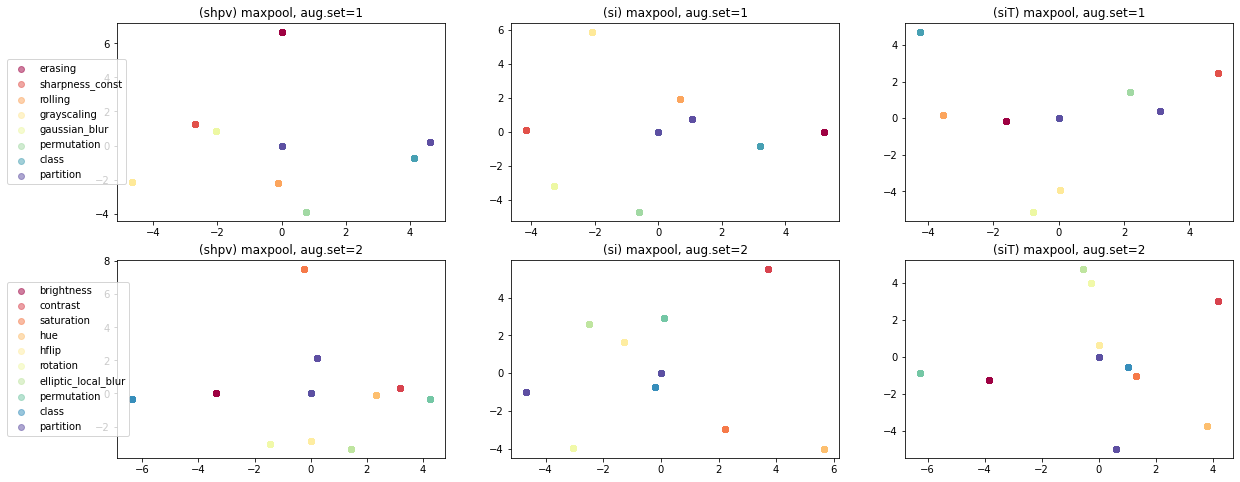

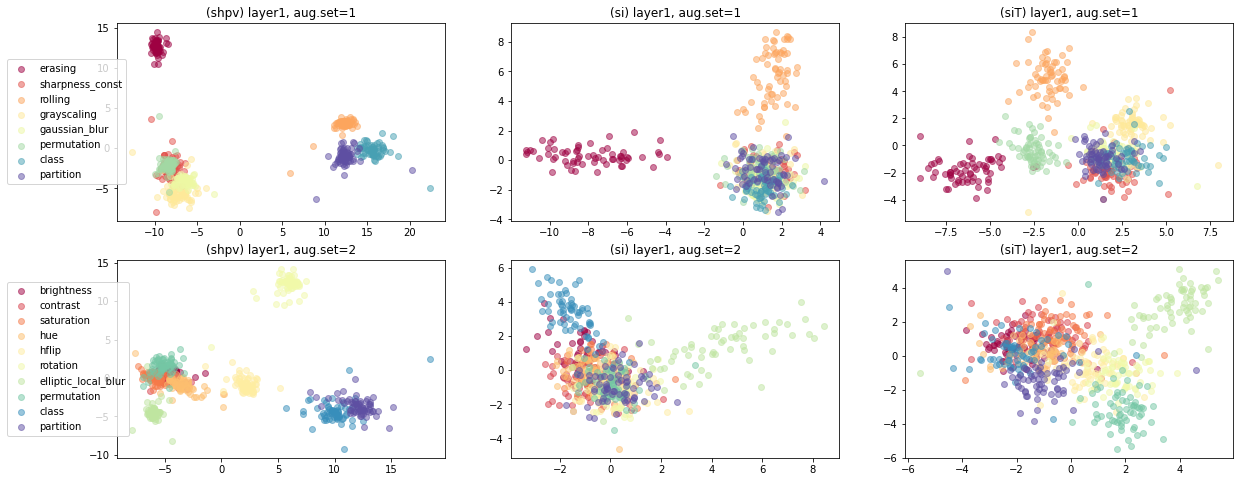

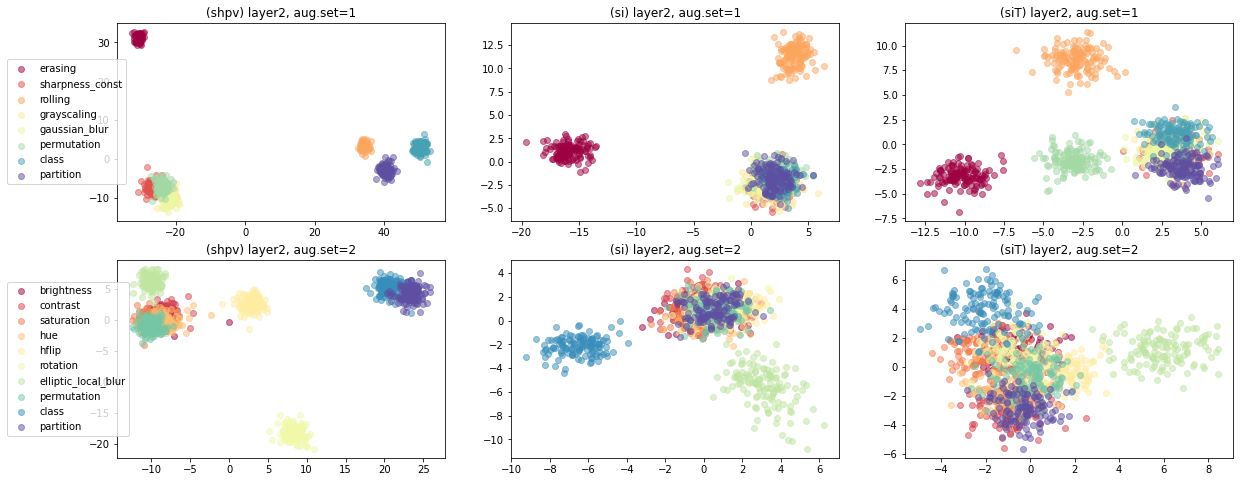

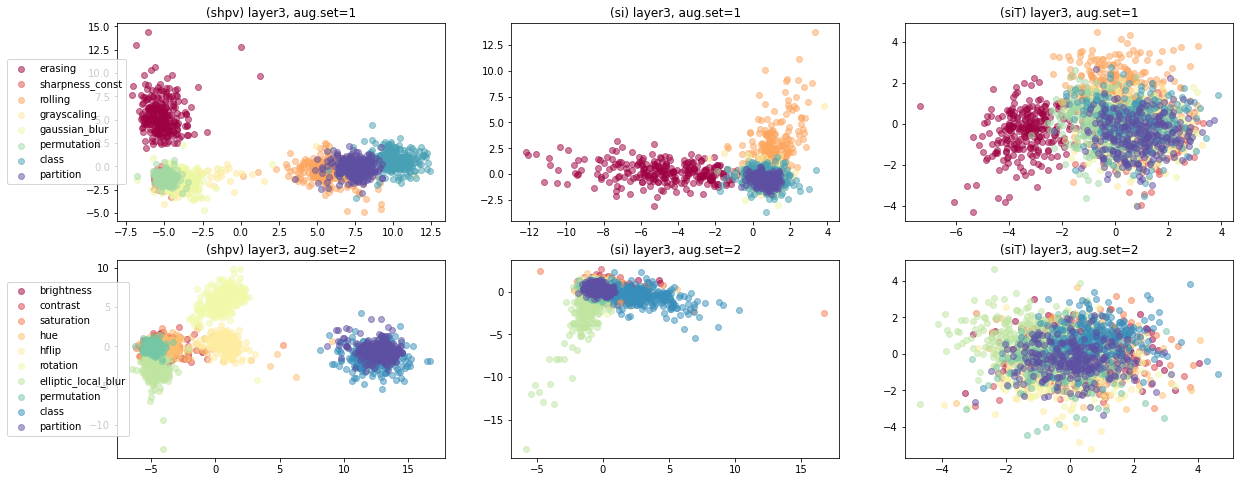

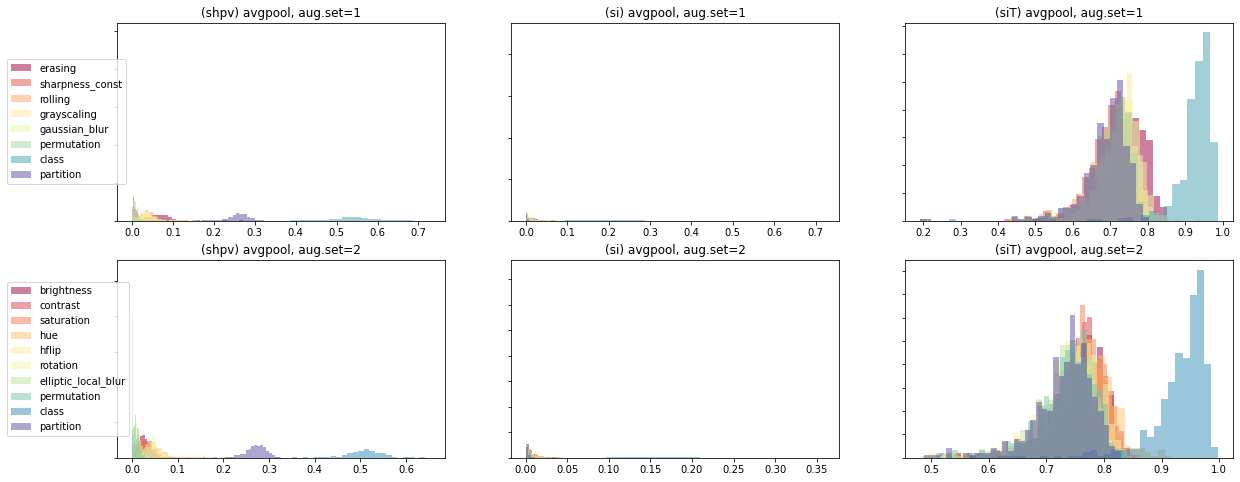

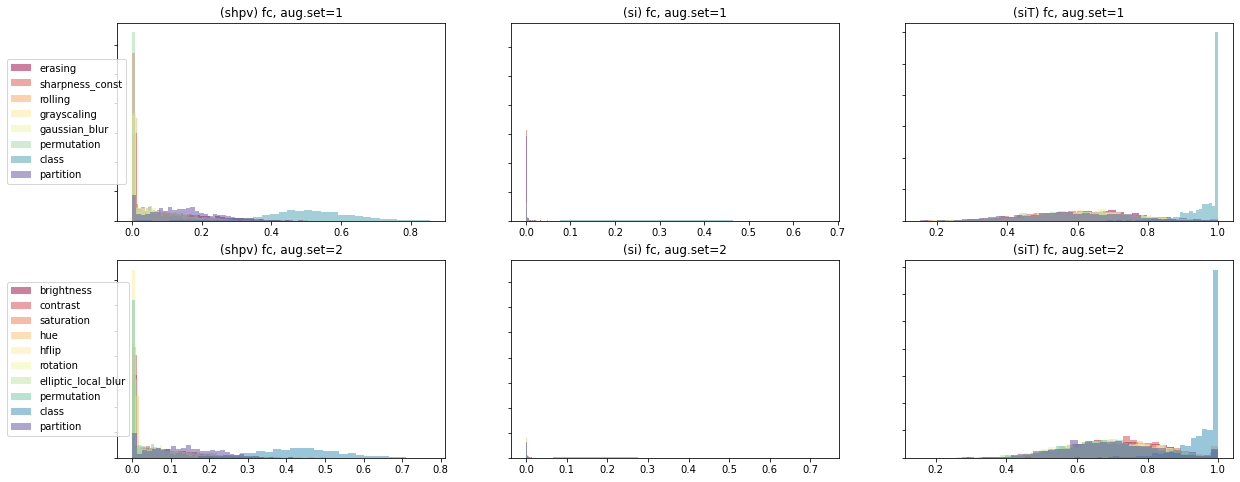

In [39]:
discriminant_analysis.plot.plot_lda_2d_projections_and_hists(
    resnet18_projected_sensitivity_values_dict,
    resnet18_sensitivity_values_dict,
    resnet18_network_modules,
    augmentation_set_numbers_list,
    values_names,
    resnet18_n_conv_modules,
    extract_auxilliary_names=True,
    figsize=figsize_lda,
    cmap='Spectral',
    show=True,
    alpha=0.5,
)

### 3.3 LDA confusion matrices

[[$\leftarrow$Prev.subsect.]](#3.2-2D-LDA-projections)$\quad$[[Back to section]](#3.-ResNet18)$\quad$

In [ ]:
resnet18_conf_mat_dict, resnet18_acc_dict = (
    discriminant_analysis.compute.compute_mean_valid_confusion_matrices(
        resnet18_sensitivity_values_dict,
        resnet18_network_modules,
        augmentation_set_numbers_list,
        values_names,
        resnet18_n_conv_modules,
        repeated_kfold_n_splits=5,
        repeated_kfold_n_repeats=100,
        random_state=0,
        extract_auxilliary_names=True,
    )
)

In [ ]:
resnet18_cmacc_filename = 'lda_resnet18_conf_mat_acc.pkl'
resnet18_cmacc_save_path = os.path.join(
    activations_dirname, resnet18_cmacc_filename
)

In [ ]:
data_loader.utils.save_pickled_data(
    {
        'resnet18_conf_mat_dict': resnet18_conf_mat_dict,
        'resnet18_acc_dict': resnet18_acc_dict,
    },
    resnet18_cmacc_save_path
)

In [43]:
tmp = data_loader.utils.load_pickled_data(resnet18_cmacc_save_path)
resnet18_conf_mat_dict = tmp['resnet18_conf_mat_dict']
resnet18_acc_dict = tmp['resnet18_acc_dict']


			maxpool



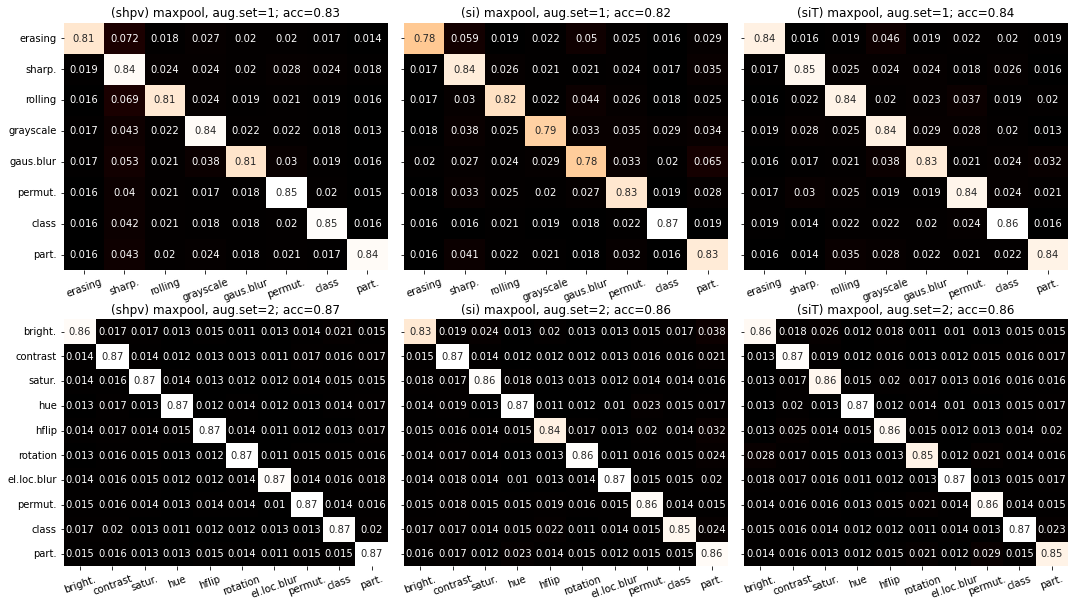


			layer1



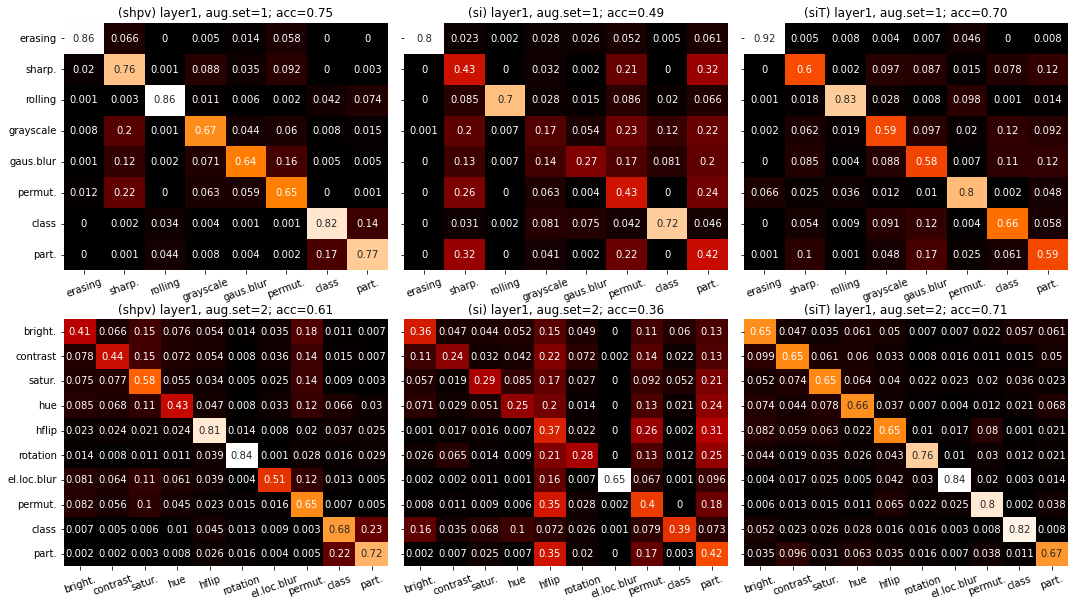


			layer2



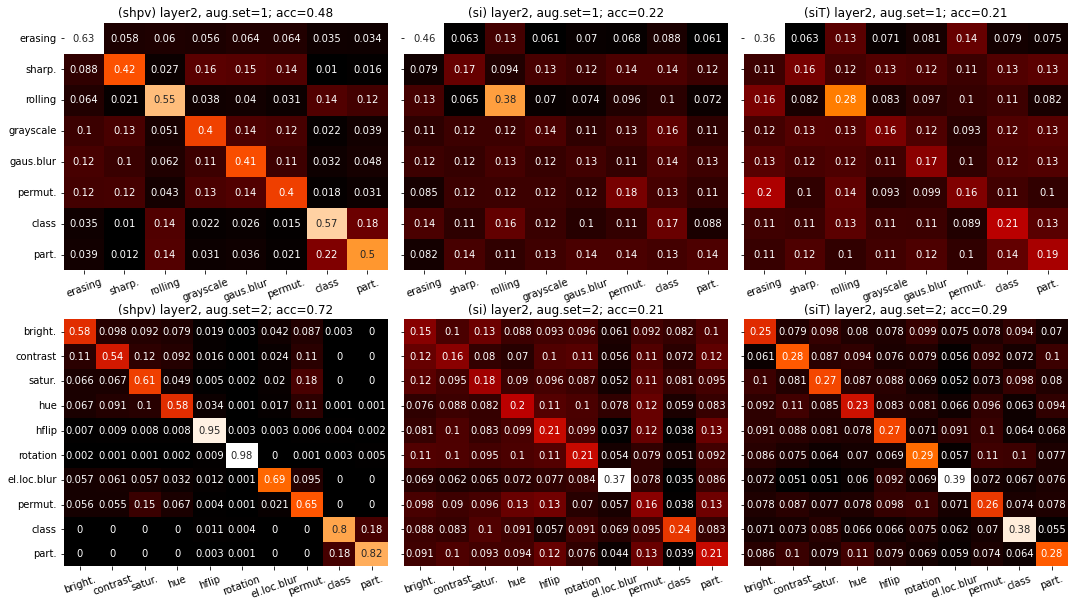


			layer3



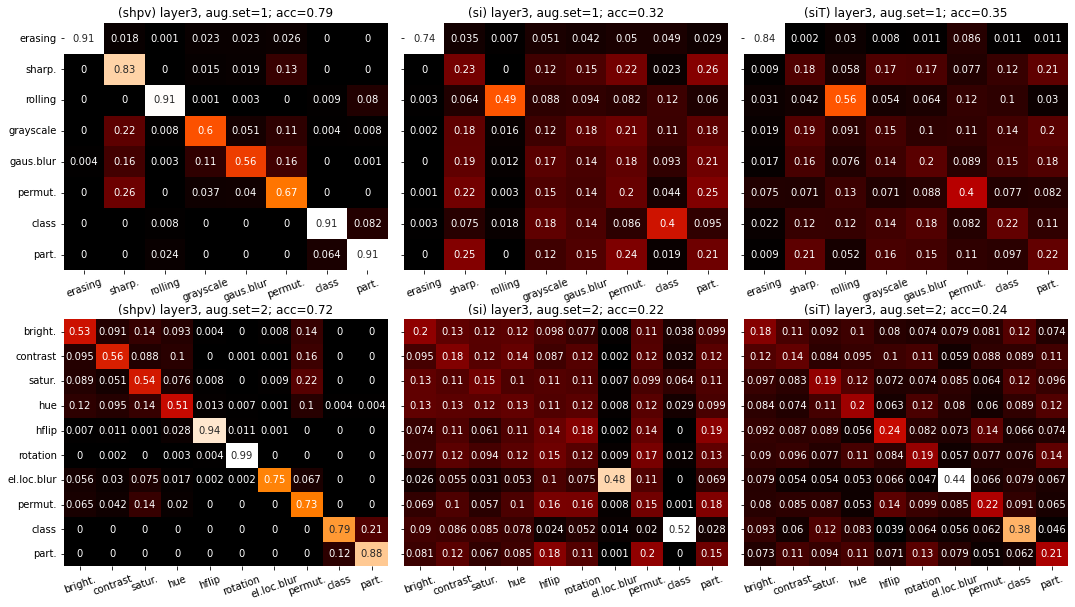

In [44]:
save_dirname = '../results/resnet18/lda_confmat/'
os.makedirs(save_dirname, exist_ok=True)
save_filename_base = f'lda_confmat'

discriminant_analysis.plot.plot_confusion_matrices(
    resnet18_conf_mat_dict,
    resnet18_acc_dict,
    resnet18_network_modules,
    augmentation_set_numbers_list,
    values_names,
    resnet18_n_conv_modules,
    extract_auxilliary_names=True,
    which='valid',
    n_round=3,
    figsize=(18, 10),
    cmap='gist_heat',
    show=True,
    save_dirname=save_dirname,
    save_filename_base=save_filename_base,
)